In [1]:
# # QC tensorflow installation
# import tensorflow as tf
# import keras
# print(tf.__version__)
# print(keras.__version__)

# Command Space
# %

## Import Libraries

In [2]:
# Import required libraries
import numpy as np
import tensorflow as tf
# from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import os

## Load CIFAR-10 Dataset

We load the CIFAR-10 dataset, perform some preprocessing like normalization and one hot encoding of labels/targets.

In [3]:
import numpy as np
import os

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10_train_test(data_dir):
    """
    Function to load CIFAR-10 training and test data.

    Args:
    data_dir (str): Path to the directory containing CIFAR-10 data files.

    Returns:
    X_train (ndarray): Training data features
    Y_train (ndarray): Training data labels
    X_test (ndarray): Test data features
    Y_test (ndarray): Test data labels
    """
    X_train = []
    Y_train = []

    for i in range(1, 6):  # Load training data from 5 batches
        batch_file = os.path.join(data_dir, 'data_batch_' + str(i))
        batch_data = unpickle(batch_file)
        X_train.append(batch_data[b'data'])
        Y_train += batch_data[b'labels']

    X_train = np.concatenate(X_train, axis=0)
    Y_train = np.array(Y_train)

    # Load test data from the test batch
    test_batch_file = os.path.join(data_dir, 'test_batch')
    test_batch_data = unpickle(test_batch_file)

    X_test = test_batch_data[b'data']
    Y_test = np.array(test_batch_data[b'labels'])

    # Reshaping and re-arranging color channels to represent RGB image required as input to CNN
    # Reshape to (50000, 3, 32, 32) and move the color channel axis to the last dimension
    X_train = X_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    X_test = X_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    return X_train, Y_train, X_test, Y_test


Create validation data from train set (20% split):

In [4]:
from sklearn.model_selection import train_test_split

# Directory containing CIFAR-10 data files
data_dir = 'dataset\cifar-10-python\cifar-10-batches-py'

# Load CIFAR-10 training and test data
X_train, Y_train, X_test, Y_test = load_cifar10_train_test(data_dir)

# Split the training data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [5]:
# Ensuring we parsed the data correctly:
print('Train Set:')
print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('Validation Set:')
print('X_val shape: ', X_val.shape)
print('Y_val shape: ', Y_val.shape)
print('Test Set:')
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)

Train Set:
X_train shape:  (40000, 32, 32, 3)
Y_train shape:  (40000,)
Validation Set:
X_val shape:  (10000, 32, 32, 3)
Y_val shape:  (10000,)
Test Set:
X_test shape:  (10000, 32, 32, 3)
Y_test shape:  (10000,)


### Setup ImageDataGenerator

In order to make the most of fewer training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

NOTE: ImageDataGenerator will NOT add new images to your data set in a sense that it will not make your epochs bigger. Instead, in each epoch it will provide slightly altered images (depending on your configuration). It will always generate new images, no matter how many epochs you have.

So in each epoch model will train on different images, but not too different. This should prevent overfitting and in some way simulates online learning.

In [6]:
from keras.preprocessing.image import ImageDataGenerator

# Construct the training image generator for data augmentation
datagen = ImageDataGenerator(
        rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        # brightness_range=[0.2,1.0] # brightness
)

# For purposes of creating a baseline, construct empty ImageDataGenerator
# datagen = ImageDataGenerator()

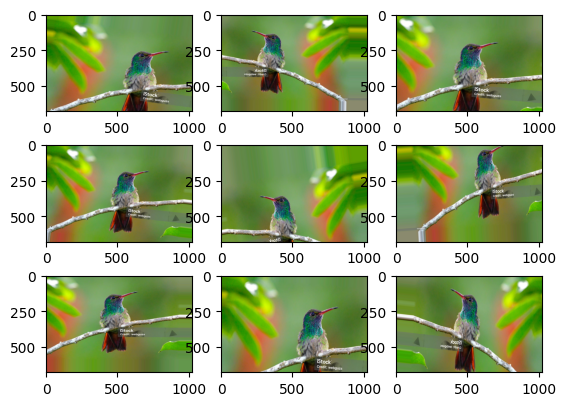

In [7]:
# Example of image augmentation on sample image:
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from matplotlib import pyplot


img = load_img('bird.jpeg') # load image
data = img_to_array(img) # convert to numpy array
samples = expand_dims(data, 0) # expand dimension to one sample

# Prepare iterator
it = datagen.flow(samples, batch_size=1)

# Generate samples and plot
for i in range(9):
    pyplot.subplot(330 + 1 + i) # define subplot
    batch = it.next() # generate batch of images
    image = batch[0].astype('uint8') # convert to unsigned integers
    pyplot.imshow(image)

# show the figure
pyplot.show()
# Adapted code for displaying augmentation results: https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

### Pre-processing dataset

In [8]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# One-hot encode the labels
Y_train = to_categorical(Y_train, 10)
Y_test = to_categorical(Y_test, 10)
Y_val = to_categorical(Y_val, 10)

## Build and Train Model

The following cell has the supporting utility functions to plot accuracy curves, loss curves from training process and final evaluation of the classification model. I have provided inline comments explaining purpose of each function and code used. 

In [9]:
# Import required libraries
import matplotlib.pyplot as plt

def plot_accuracy(history, title):
    """
    Function to plot accuracy curves for both training and validation sets.

    Args:
    history (History): Keras History object containing training history
    title (str): Title of the plot
    """
    new_title = title + " Accuracy"
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(new_title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    save_plot(plt, new_title)
    plt.show()
    
def plot_multiple_accuracies(models, title):
    """
    Function to plot accuracy curves for both training and validation sets of multiple models at once.

    Args:
    models (Dictionary): Contains Keras History objects with training history assigned by keys that pertain to the hyperparameter value used
    title (str): Title of the plot
    """
    new_title = title + " Accuracy"
    for key in models.keys():
        history = models[key]
        plt.plot(history.history['accuracy'], label='train_accuracy' + "_" + key)
        plt.plot(history.history['val_accuracy'], label='val_accuracy' + "_" + key)
    plt.title(new_title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    save_plot(plt, new_title)
    plt.show()

def plot_loss(history, title):
    """
    Function to plot loss curves for both training and validation sets.

    Args:
    history (History): Keras History object containing training history
    title (str): Title of the plot
    """
    new_title = title + " Loss"
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(new_title = title + " Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    save_plot(plt, new_title = title + " Loss")
    plt.show()
    
def plot_multiple_losses(models, title):
    """
    Function to plot loss curves for both training and validation sets.

    Args:
    models (Dictionary): Contains Keras History objects with training history assigned by keys that pertain to the hyperparameter value used
    title (str): Title of the plot
    """
    new_title = title + " Loss"
    for key in models.keys():
        history = models[key]
        plt.plot(history.history['loss'], label='train_loss' + "_" + key)
        plt.plot(history.history['val_loss'], label='val_loss' + "_" + key)
    plt.title(new_title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    save_plot(plt, new_title)
    plt.show()

def evaluate_model(model, X_test, Y_test):
    """
    Function to evaluate the performance of a trained model on the test dataset.

    Args:
    model (Sequential): Trained Keras model
    X_test (ndarray): Test dataset features
    Y_test (ndarray): One-hot encoded labels for test dataset
    """
    _, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print("Test Accuracy: %.2f%%" % (accuracy * 100))
    return accuracy * 100
    
def save_plot(plt, name):
    """
    Function to save a plot. Call function before plt.show().

    Args:
    plt (matplotlib.pyplot object): Plot to save
    name (String): A String for the name of the output file. Cannot contain spaces
    """
    filepath = "Graphs/" + name
    # if os.path.isfile(filepath):
    #     filepath += "_second"
    #     print("Same filename. Please alter the params_string. You will not get another warning before losing figures!!")
    plt.savefig(filepath)


In [10]:
from tensorflow.keras.layers import Input, Add, Activation, AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

def resnet_block(inputs, filters, kernel_size, strides, skip_kernel_size=(1, 1), activation='relu', num_layers=2, dropout=0):
    """
    Function to create a single ResNet block.

    Args:
    inputs (tensor): Input tensor
    filters (int): Number of filters in the convolutional layers
    kernel_size (int or tuple): Size of the convolutional kernel
    strides (int or tuple): Strides of the convolutional kernel
    skip_kernel_size (int or tuple): Size of the skip connection kernel
    activation (str): Activation function to use
    num_layers (int): Number of convolutional layers per block
    dropout (int): A value from 0-1 for dropout regularization

    Returns:
    tensor: Output tensor of the ResNet block
    """
    shortcut = inputs

    # Create initial convolutional layer and batch normalization without an activation layer afterwards
    x = Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
    x = Dropout(dropout)(x)
    x = BatchNormalization()(x)
    
    # Create (num_layers - 1) convolutional layers with activation layer beforehand
    # Final layer does not have an activation layer as desired
    if num_layers > 1:
        for i in range(num_layers - 1):
            x = Activation(activation)(x)
            x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
            x = Dropout(dropout)(x)
            x = BatchNormalization()(x)
    

    # Shortcut connection
    if strides != 1 or inputs.shape[-1] != filters:
        # change (1,1) to variable (the kernel size in the ith skip connection)
        shortcut = Conv2D(filters, skip_kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(inputs)
        shortcut = Dropout(dropout)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation(activation)(x)
    return x

def build_resnet(init_filters=64, res_layers=[2, 2], conv_kernel_size=(3,3), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(8, 8), optimizer='adam', dropout=0):
    """
    Function to build a ResNet model using multiple Resnet style blocks.
    
    Args:
    init_filters (int): Number of filters in the first layer
    res_layers (list of ints): Network architecture as a list where the length of the list is the number of Residual Layers and the value of each element is the number of blocks in that layer
    conv_kernel_size (int or tuple): Size of the convolutional kernel
    skip_kernel_size (int or tuple): Size of the skip connection kernel
    conv_per_layer (int): Number of convolutional layers per residual block
    pool_size (int or tuple): Size of the pooling layer
    optimizer (String): Acceptable keras optimizers such as SGD or adam
    dropout (int): A value from 0-1 for dropout regularization

    Returns:
    model (Model): Compiled ResNet model
    """
    inputs = Input(shape=(32, 32, 3))
    num_filters = init_filters
    num_blocks_list = res_layers  # ResNet Style architecture for CIFAR-10

    x = Conv2D(num_filters, conv_kernel_size, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Add ResNet blocks
    for i, num_blocks in enumerate(num_blocks_list):
        for j in range(num_blocks):
            strides = 1
            if i > 0 and j == 0:  # Downsample at the beginning of each stage
                strides = 2
            x = resnet_block(x, num_filters, conv_kernel_size, strides, skip_kernel_size=skip_kernel_size, num_layers=conv_per_layer, dropout=dropout)

        num_filters *= 2  # Double the number of filters after each stage

    x = AveragePooling2D(pool_size=pool_size)(x) # pool size could be hyperparameter
    x = Flatten()(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    # optimizer can be a parameter: vanilla sgd, sgd with fixed learning rate, or adam 
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [11]:
# Build ResNet Model 1
resnet_model_1 = build_resnet(init_filters=64, res_layers=[2], conv_kernel_size=(3,3), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(2, 2), optimizer='SGD', dropout=0)
resnet_model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 64)   0           ['batch_normalization[0][0]']

In [12]:
# Build ResNet Model 2
resnet_model_2 = build_resnet(init_filters=64, res_layers=[2, 2], conv_kernel_size=(3,3), skip_kernel_size=(1,1), conv_per_layer=2, pool_size=(2, 2), optimizer='SGD', dropout=0)
resnet_model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 32, 32, 64)  256         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_5 (Activation)      (None, 32, 32, 64)   0           ['batch_normalization_5[0][

In [13]:
# Build ResNet Model 3
resnet_model_3 = build_resnet(init_filters=64, res_layers=[2, 2, 2], conv_kernel_size=(3,3), skip_kernel_size=(1,1), conv_per_layer=2, pool_size=(2, 2), optimizer='SGD', dropout=0)
resnet_model_3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_15 (Conv2D)             (None, 32, 32, 64)   1792        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_15 (BatchN  (None, 32, 32, 64)  256         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_14 (Activation)     (None, 32, 32, 64)   0           ['batch_normalization_15[0]

In [14]:
# # Build ResNet Model 4
# resnet_model_4 = build_resnet(init_filters=64, res_layers=[2, 2], conv_kernel_size=(3,3), skip_kernel_size=(1, 1), conv_per_layer=2, pool_size=(2, 2), optimizer='SGD', dropout=0)
# resnet_model_4.summary()

### Enabling Keras Callbacks

Callback to save the Keras model weights after every epoch that obtains the best validation accuracy thus far.

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Title of the Hypothesis Tested
title = "Varying Number of Residual Layers"

# These are used to distinguish the models from each other
param_1 = "One Residual Layer"
param_2 = "Two Residual Layers"
param_3 = "Three Residual Layers"
# param_4 = ""

checkpoint_filepath_1 = 'ckpt/' + title + '/' + param_1
checkpoint_filepath_2 = 'ckpt/' + title + '/' + param_2 
checkpoint_filepath_3 = 'ckpt/' + title + '/' + param_3
# checkpoint_filepath_4 = 'ckpt/' + title + '/' + param_4

# Defining callback
model_checkpoint_callback_1 = ModelCheckpoint(
    filepath=checkpoint_filepath_1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model_checkpoint_callback_2 = ModelCheckpoint(
    filepath=checkpoint_filepath_2,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model_checkpoint_callback_3 = ModelCheckpoint(
    filepath=checkpoint_filepath_3,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# model_checkpoint_callback_4 = ModelCheckpoint(
#     filepath=checkpoint_filepath_4,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

## Model Training

In [16]:
# Augmenting on the fly with datagen.flow()
batch_size=64
epochs=30

# For running multiple networks at the same time, create dictionary to store history values and lists to store all other info
histories = {}
keys = [param_1, param_2, param_3] #, param_4
models = [resnet_model_1, resnet_model_2, resnet_model_3] #, resnet_model_4
checkpoints = [model_checkpoint_callback_1, model_checkpoint_callback_2, model_checkpoint_callback_3] #, model_checkpoint_callback_4
# After creating these lists, the keys list is used to defined the keys of the histories dictionary based on the parameter names above
# The models and checkpoints lists hold the models and checkpoint callbacks defined above
for i in range(len(models)):
# Directly use .flow() to load our dataset in batches for training
    histories[keys[i]] = models[i].fit(datagen.flow(X_train, Y_train, batch_size=batch_size), 
                                    epochs = epochs, # set number of epochs
                                    steps_per_epoch = X_train.shape[0]//batch_size, # number of images composing one epoch
                                    validation_data = (X_val, Y_val), # data for validation
                                    callbacks=[checkpoints[i]], # model checkpoint
                                    verbose=1)

Epoch 1/30
625/625 [==============================] - ETA: 0s - loss: 3.1399 - accuracy: 0.3174

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


625/625 [==============================] - 21s 29ms/step - loss: 3.1399 - accuracy: 0.3174 - val_loss: 1.7928 - val_accuracy: 0.3863
Epoch 2/30
625/625 [==============================] - ETA: 0s - loss: 1.5965 - accuracy: 0.4238

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


625/625 [==============================] - 18s 29ms/step - loss: 1.5965 - accuracy: 0.4238 - val_loss: 1.3625 - val_accuracy: 0.5173
Epoch 3/30
625/625 [==============================] - 16s 26ms/step - loss: 1.4799 - accuracy: 0.4662 - val_loss: 1.3694 - val_accuracy: 0.5087
Epoch 4/30
623/625 [============================>.] - ETA: 0s - loss: 1.4094 - accuracy: 0.4938

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


625/625 [==============================] - 18s 28ms/step - loss: 1.4093 - accuracy: 0.4939 - val_loss: 1.2459 - val_accuracy: 0.5526
Epoch 5/30
625/625 [==============================] - 16s 26ms/step - loss: 1.3530 - accuracy: 0.5142 - val_loss: 1.3083 - val_accuracy: 0.5472
Epoch 6/30
624/625 [============================>.] - ETA: 0s - loss: 1.2958 - accuracy: 0.5347

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


625/625 [==============================] - 18s 28ms/step - loss: 1.2954 - accuracy: 0.5347 - val_loss: 1.1469 - val_accuracy: 0.5951
Epoch 7/30
625/625 [==============================] - 16s 26ms/step - loss: 1.2529 - accuracy: 0.5526 - val_loss: 1.3100 - val_accuracy: 0.5564
Epoch 8/30
625/625 [==============================] - 16s 26ms/step - loss: 1.2240 - accuracy: 0.5622 - val_loss: 1.3242 - val_accuracy: 0.5563
Epoch 9/30
625/625 [==============================] - ETA: 0s - loss: 1.1847 - accuracy: 0.5753

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


625/625 [==============================] - 18s 28ms/step - loss: 1.1847 - accuracy: 0.5753 - val_loss: 1.1096 - val_accuracy: 0.6176
Epoch 10/30
624/625 [============================>.] - ETA: 0s - loss: 1.1539 - accuracy: 0.5930

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


625/625 [==============================] - 18s 29ms/step - loss: 1.1540 - accuracy: 0.5930 - val_loss: 1.0755 - val_accuracy: 0.6208
Epoch 11/30
625/625 [==============================] - ETA: 0s - loss: 1.1353 - accuracy: 0.5979

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


625/625 [==============================] - 18s 29ms/step - loss: 1.1353 - accuracy: 0.5979 - val_loss: 1.0680 - val_accuracy: 0.6315
Epoch 12/30
625/625 [==============================] - 17s 27ms/step - loss: 1.1075 - accuracy: 0.6087 - val_loss: 1.1447 - val_accuracy: 0.6021
Epoch 13/30
625/625 [==============================] - 17s 27ms/step - loss: 1.0884 - accuracy: 0.6142 - val_loss: 1.2227 - val_accuracy: 0.5993
Epoch 14/30
623/625 [============================>.] - ETA: 0s - loss: 1.0708 - accuracy: 0.6212

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


625/625 [==============================] - 18s 29ms/step - loss: 1.0708 - accuracy: 0.6211 - val_loss: 1.0218 - val_accuracy: 0.6458
Epoch 15/30
625/625 [==============================] - ETA: 0s - loss: 1.0535 - accuracy: 0.6300

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


625/625 [==============================] - 19s 30ms/step - loss: 1.0535 - accuracy: 0.6300 - val_loss: 0.9916 - val_accuracy: 0.6597
Epoch 16/30
624/625 [============================>.] - ETA: 0s - loss: 1.0308 - accuracy: 0.6380

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


625/625 [==============================] - 18s 29ms/step - loss: 1.0306 - accuracy: 0.6381 - val_loss: 0.9169 - val_accuracy: 0.6765
Epoch 17/30
625/625 [==============================] - 16s 26ms/step - loss: 1.0176 - accuracy: 0.6423 - val_loss: 1.3799 - val_accuracy: 0.5782
Epoch 18/30
625/625 [==============================] - 17s 27ms/step - loss: 0.9973 - accuracy: 0.6493 - val_loss: 0.9925 - val_accuracy: 0.6588
Epoch 19/30
625/625 [==============================] - 16s 26ms/step - loss: 0.9842 - accuracy: 0.6542 - val_loss: 0.9863 - val_accuracy: 0.6614
Epoch 20/30
625/625 [==============================] - 17s 27ms/step - loss: 0.9726 - accuracy: 0.6587 - val_loss: 1.2730 - val_accuracy: 0.5992
Epoch 21/30
625/625 [==============================] - 16s 26ms/step - loss: 0.9536 - accuracy: 0.6668 - val_loss: 1.1758 - val_accuracy: 0.6208
Epoch 22/30
625/625 [==============================] - 16s 26ms/step - loss: 0.9434 - accuracy: 0.6704 - val_loss: 1.0190 - val_accuracy: 0.67

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


625/625 [==============================] - 18s 28ms/step - loss: 0.9282 - accuracy: 0.6761 - val_loss: 0.9455 - val_accuracy: 0.6855
Epoch 24/30
624/625 [============================>.] - ETA: 0s - loss: 0.9249 - accuracy: 0.6777

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


625/625 [==============================] - 18s 28ms/step - loss: 0.9247 - accuracy: 0.6778 - val_loss: 0.8861 - val_accuracy: 0.7007
Epoch 25/30
625/625 [==============================] - 16s 26ms/step - loss: 0.9042 - accuracy: 0.6859 - val_loss: 1.4624 - val_accuracy: 0.5837
Epoch 26/30
625/625 [==============================] - 16s 26ms/step - loss: 0.8965 - accuracy: 0.6875 - val_loss: 0.9849 - val_accuracy: 0.6743
Epoch 27/30
625/625 [==============================] - ETA: 0s - loss: 0.8856 - accuracy: 0.6920

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


625/625 [==============================] - 18s 29ms/step - loss: 0.8856 - accuracy: 0.6920 - val_loss: 0.8536 - val_accuracy: 0.7104
Epoch 28/30
623/625 [============================>.] - ETA: 0s - loss: 0.8737 - accuracy: 0.6963

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\One Residual Layer\assets


625/625 [==============================] - 18s 28ms/step - loss: 0.8738 - accuracy: 0.6960 - val_loss: 0.8591 - val_accuracy: 0.7123
Epoch 29/30
625/625 [==============================] - 16s 26ms/step - loss: 0.8620 - accuracy: 0.6990 - val_loss: 1.4769 - val_accuracy: 0.6044
Epoch 30/30
625/625 [==============================] - 16s 26ms/step - loss: 0.8486 - accuracy: 0.7008 - val_loss: 1.2181 - val_accuracy: 0.6280
Epoch 1/30
624/625 [============================>.] - ETA: 0s - loss: 2.3534 - accuracy: 0.3196

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


625/625 [==============================] - 20s 31ms/step - loss: 2.3524 - accuracy: 0.3196 - val_loss: 1.5397 - val_accuracy: 0.4500
Epoch 2/30
625/625 [==============================] - ETA: 0s - loss: 1.6045 - accuracy: 0.4177

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


625/625 [==============================] - 20s 31ms/step - loss: 1.6045 - accuracy: 0.4177 - val_loss: 1.4626 - val_accuracy: 0.4637
Epoch 3/30
623/625 [============================>.] - ETA: 0s - loss: 1.4872 - accuracy: 0.4620

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


625/625 [==============================] - 20s 31ms/step - loss: 1.4870 - accuracy: 0.4621 - val_loss: 1.4311 - val_accuracy: 0.5093
Epoch 4/30
625/625 [==============================] - ETA: 0s - loss: 1.4032 - accuracy: 0.4926

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


625/625 [==============================] - 19s 30ms/step - loss: 1.4032 - accuracy: 0.4926 - val_loss: 1.3836 - val_accuracy: 0.5287
Epoch 5/30
625/625 [==============================] - ETA: 0s - loss: 1.3288 - accuracy: 0.5222

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


625/625 [==============================] - 19s 30ms/step - loss: 1.3288 - accuracy: 0.5222 - val_loss: 1.1650 - val_accuracy: 0.5750
Epoch 6/30
624/625 [============================>.] - ETA: 0s - loss: 1.2708 - accuracy: 0.5467

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


625/625 [==============================] - 19s 31ms/step - loss: 1.2708 - accuracy: 0.5468 - val_loss: 1.2039 - val_accuracy: 0.5800
Epoch 7/30
624/625 [============================>.] - ETA: 0s - loss: 1.2216 - accuracy: 0.5652

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


625/625 [==============================] - 20s 32ms/step - loss: 1.2213 - accuracy: 0.5653 - val_loss: 1.0668 - val_accuracy: 0.6234
Epoch 8/30
625/625 [==============================] - 17s 27ms/step - loss: 1.1675 - accuracy: 0.5814 - val_loss: 1.2245 - val_accuracy: 0.5938
Epoch 9/30
625/625 [==============================] - ETA: 0s - loss: 1.1195 - accuracy: 0.6012

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


625/625 [==============================] - 19s 31ms/step - loss: 1.1195 - accuracy: 0.6012 - val_loss: 1.0381 - val_accuracy: 0.6439
Epoch 10/30
625/625 [==============================] - 16s 26ms/step - loss: 1.0825 - accuracy: 0.6117 - val_loss: 1.0942 - val_accuracy: 0.6257
Epoch 11/30
625/625 [==============================] - 17s 27ms/step - loss: 1.0469 - accuracy: 0.6281 - val_loss: 1.0592 - val_accuracy: 0.6401
Epoch 12/30
625/625 [==============================] - 16s 26ms/step - loss: 1.0172 - accuracy: 0.6419 - val_loss: 1.2919 - val_accuracy: 0.5906
Epoch 13/30
625/625 [==============================] - ETA: 0s - loss: 0.9780 - accuracy: 0.6545

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


625/625 [==============================] - 20s 31ms/step - loss: 0.9780 - accuracy: 0.6545 - val_loss: 0.9628 - val_accuracy: 0.6741
Epoch 14/30
625/625 [==============================] - ETA: 0s - loss: 0.9523 - accuracy: 0.6646

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


625/625 [==============================] - 19s 31ms/step - loss: 0.9523 - accuracy: 0.6646 - val_loss: 0.9909 - val_accuracy: 0.6744
Epoch 15/30
625/625 [==============================] - 17s 27ms/step - loss: 0.9370 - accuracy: 0.6683 - val_loss: 1.3590 - val_accuracy: 0.6096
Epoch 16/30
625/625 [==============================] - 17s 27ms/step - loss: 0.9091 - accuracy: 0.6800 - val_loss: 1.0224 - val_accuracy: 0.6730
Epoch 17/30
624/625 [============================>.] - ETA: 0s - loss: 0.8863 - accuracy: 0.6914

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


625/625 [==============================] - 19s 31ms/step - loss: 0.8863 - accuracy: 0.6913 - val_loss: 0.8294 - val_accuracy: 0.7149
Epoch 18/30
625/625 [==============================] - 17s 27ms/step - loss: 0.8644 - accuracy: 0.6975 - val_loss: 1.1290 - val_accuracy: 0.6458
Epoch 19/30
624/625 [============================>.] - ETA: 0s - loss: 0.8428 - accuracy: 0.7065

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


625/625 [==============================] - 19s 31ms/step - loss: 0.8427 - accuracy: 0.7066 - val_loss: 0.8081 - val_accuracy: 0.7313
Epoch 20/30
625/625 [==============================] - 17s 27ms/step - loss: 0.8263 - accuracy: 0.7095 - val_loss: 1.3860 - val_accuracy: 0.6277
Epoch 21/30
625/625 [==============================] - 17s 26ms/step - loss: 0.8082 - accuracy: 0.7193 - val_loss: 0.8651 - val_accuracy: 0.7158
Epoch 22/30
625/625 [==============================] - ETA: 0s - loss: 0.7944 - accuracy: 0.7214

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


625/625 [==============================] - 20s 32ms/step - loss: 0.7944 - accuracy: 0.7214 - val_loss: 0.7545 - val_accuracy: 0.7423
Epoch 23/30
625/625 [==============================] - 17s 27ms/step - loss: 0.7766 - accuracy: 0.7305 - val_loss: 0.8065 - val_accuracy: 0.7301
Epoch 24/30
625/625 [==============================] - ETA: 0s - loss: 0.7640 - accuracy: 0.7327

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


625/625 [==============================] - 19s 31ms/step - loss: 0.7640 - accuracy: 0.7327 - val_loss: 0.7633 - val_accuracy: 0.7489
Epoch 25/30
625/625 [==============================] - 17s 28ms/step - loss: 0.7493 - accuracy: 0.7382 - val_loss: 0.9100 - val_accuracy: 0.7139
Epoch 26/30
624/625 [============================>.] - ETA: 0s - loss: 0.7282 - accuracy: 0.7474

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


625/625 [==============================] - 20s 31ms/step - loss: 0.7283 - accuracy: 0.7475 - val_loss: 0.6471 - val_accuracy: 0.7780
Epoch 27/30
625/625 [==============================] - 17s 28ms/step - loss: 0.7187 - accuracy: 0.7488 - val_loss: 0.8532 - val_accuracy: 0.7292
Epoch 28/30
625/625 [==============================] - 17s 27ms/step - loss: 0.7066 - accuracy: 0.7537 - val_loss: 0.7541 - val_accuracy: 0.7527
Epoch 29/30
625/625 [==============================] - 17s 27ms/step - loss: 0.6946 - accuracy: 0.7601 - val_loss: 1.0026 - val_accuracy: 0.6987
Epoch 30/30
625/625 [==============================] - ETA: 0s - loss: 0.6849 - accuracy: 0.7602

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Two Residual Layers\assets


625/625 [==============================] - 20s 32ms/step - loss: 0.6849 - accuracy: 0.7602 - val_loss: 0.6347 - val_accuracy: 0.7887
Epoch 1/30
623/625 [============================>.] - ETA: 0s - loss: 2.0266 - accuracy: 0.3423

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


625/625 [==============================] - 23s 35ms/step - loss: 2.0264 - accuracy: 0.3424 - val_loss: 1.6340 - val_accuracy: 0.4367
Epoch 2/30
624/625 [============================>.] - ETA: 0s - loss: 1.5707 - accuracy: 0.4386

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


625/625 [==============================] - 23s 36ms/step - loss: 1.5708 - accuracy: 0.4385 - val_loss: 1.5423 - val_accuracy: 0.4707
Epoch 3/30
625/625 [==============================] - ETA: 0s - loss: 1.4426 - accuracy: 0.4814

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


625/625 [==============================] - 22s 35ms/step - loss: 1.4426 - accuracy: 0.4814 - val_loss: 1.5114 - val_accuracy: 0.4880
Epoch 4/30
625/625 [==============================] - ETA: 0s - loss: 1.3601 - accuracy: 0.5106

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


625/625 [==============================] - 22s 35ms/step - loss: 1.3601 - accuracy: 0.5106 - val_loss: 1.2861 - val_accuracy: 0.5518
Epoch 5/30
625/625 [==============================] - ETA: 0s - loss: 1.2847 - accuracy: 0.5389

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


625/625 [==============================] - 22s 35ms/step - loss: 1.2847 - accuracy: 0.5389 - val_loss: 1.1893 - val_accuracy: 0.5892
Epoch 6/30
624/625 [============================>.] - ETA: 0s - loss: 1.2202 - accuracy: 0.5588

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


625/625 [==============================] - 22s 35ms/step - loss: 1.2200 - accuracy: 0.5588 - val_loss: 1.1972 - val_accuracy: 0.5893
Epoch 7/30
624/625 [============================>.] - ETA: 0s - loss: 1.1700 - accuracy: 0.5821

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


625/625 [==============================] - 22s 35ms/step - loss: 1.1699 - accuracy: 0.5821 - val_loss: 1.2525 - val_accuracy: 0.5928
Epoch 8/30
625/625 [==============================] - ETA: 0s - loss: 1.1156 - accuracy: 0.6027

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


625/625 [==============================] - 22s 35ms/step - loss: 1.1156 - accuracy: 0.6027 - val_loss: 1.0406 - val_accuracy: 0.6467
Epoch 9/30
625/625 [==============================] - 18s 28ms/step - loss: 1.0764 - accuracy: 0.6163 - val_loss: 1.0340 - val_accuracy: 0.6402
Epoch 10/30
625/625 [==============================] - 17s 28ms/step - loss: 1.0392 - accuracy: 0.6307 - val_loss: 1.1573 - val_accuracy: 0.6113
Epoch 11/30
625/625 [==============================] - 17s 27ms/step - loss: 1.0013 - accuracy: 0.6437 - val_loss: 1.2387 - val_accuracy: 0.6102
Epoch 12/30
625/625 [==============================] - 17s 27ms/step - loss: 0.9738 - accuracy: 0.6570 - val_loss: 1.6133 - val_accuracy: 0.5609
Epoch 13/30
625/625 [==============================] - ETA: 0s - loss: 0.9283 - accuracy: 0.6685

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


625/625 [==============================] - 21s 33ms/step - loss: 0.9283 - accuracy: 0.6685 - val_loss: 0.9258 - val_accuracy: 0.6950
Epoch 14/30
625/625 [==============================] - ETA: 0s - loss: 0.9000 - accuracy: 0.6854

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


625/625 [==============================] - 21s 34ms/step - loss: 0.9000 - accuracy: 0.6854 - val_loss: 0.8302 - val_accuracy: 0.7100
Epoch 15/30
625/625 [==============================] - 17s 28ms/step - loss: 0.8726 - accuracy: 0.6916 - val_loss: 0.9378 - val_accuracy: 0.6863
Epoch 16/30
625/625 [==============================] - ETA: 0s - loss: 0.8436 - accuracy: 0.7019

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


625/625 [==============================] - 21s 33ms/step - loss: 0.8436 - accuracy: 0.7019 - val_loss: 0.7938 - val_accuracy: 0.7269
Epoch 17/30
625/625 [==============================] - 17s 27ms/step - loss: 0.8235 - accuracy: 0.7130 - val_loss: 0.9293 - val_accuracy: 0.6866
Epoch 18/30
625/625 [==============================] - 17s 27ms/step - loss: 0.7923 - accuracy: 0.7208 - val_loss: 0.9119 - val_accuracy: 0.7099
Epoch 19/30
625/625 [==============================] - 17s 27ms/step - loss: 0.7823 - accuracy: 0.7237 - val_loss: 1.1174 - val_accuracy: 0.6569
Epoch 20/30
625/625 [==============================] - ETA: 0s - loss: 0.7574 - accuracy: 0.7345

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


625/625 [==============================] - 22s 35ms/step - loss: 0.7574 - accuracy: 0.7345 - val_loss: 0.8092 - val_accuracy: 0.7323
Epoch 21/30
625/625 [==============================] - 17s 28ms/step - loss: 0.7372 - accuracy: 0.7392 - val_loss: 1.0697 - val_accuracy: 0.6716
Epoch 22/30
625/625 [==============================] - 17s 27ms/step - loss: 0.7144 - accuracy: 0.7506 - val_loss: 0.9553 - val_accuracy: 0.7112
Epoch 23/30
625/625 [==============================] - ETA: 0s - loss: 0.7021 - accuracy: 0.7537

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


625/625 [==============================] - 21s 33ms/step - loss: 0.7021 - accuracy: 0.7537 - val_loss: 0.7574 - val_accuracy: 0.7502
Epoch 24/30
625/625 [==============================] - ETA: 0s - loss: 0.6861 - accuracy: 0.7605

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


625/625 [==============================] - 22s 34ms/step - loss: 0.6861 - accuracy: 0.7605 - val_loss: 0.6300 - val_accuracy: 0.7840
Epoch 25/30
625/625 [==============================] - 18s 28ms/step - loss: 0.6644 - accuracy: 0.7678 - val_loss: 0.8470 - val_accuracy: 0.7370
Epoch 26/30
625/625 [==============================] - 17s 28ms/step - loss: 0.6558 - accuracy: 0.7700 - val_loss: 0.7814 - val_accuracy: 0.7551
Epoch 27/30
625/625 [==============================] - 17s 28ms/step - loss: 0.6383 - accuracy: 0.7779 - val_loss: 0.7553 - val_accuracy: 0.7567
Epoch 28/30
625/625 [==============================] - 17s 27ms/step - loss: 0.6238 - accuracy: 0.7815 - val_loss: 0.7947 - val_accuracy: 0.7432
Epoch 29/30
625/625 [==============================] - 17s 28ms/step - loss: 0.6103 - accuracy: 0.7863 - val_loss: 0.6794 - val_accuracy: 0.7753
Epoch 30/30
625/625 [==============================] - ETA: 0s - loss: 0.6021 - accuracy: 0.7898

INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


INFO:tensorflow:Assets written to: ckpt/Varying Number of Residual Layers\Three Residual Layers\assets


625/625 [==============================] - 22s 35ms/step - loss: 0.6021 - accuracy: 0.7898 - val_loss: 0.5786 - val_accuracy: 0.8084


In [17]:
# resnet_history = resnet_model.fit(X_train, Y_train, batch_size=64, epochs=10, verbose=1, validation_data=(X_val, Y_val))


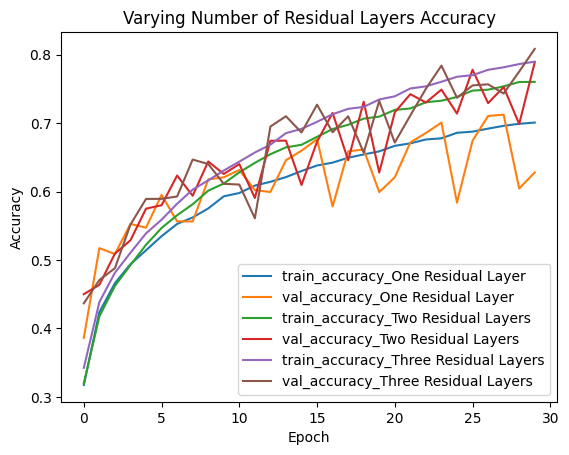

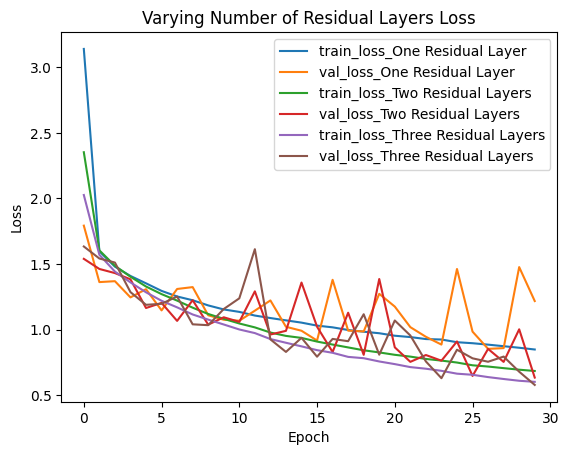

In [18]:
# Plot accuracy and loss
# accuracy_title = title + ' Accuracy'
# loss_title = title + ' Loss'
# plot_accuracy(resnet_history, accuracy_title)
# plot_loss(resnet_history, loss_title)

# Plot all models' accuracies and losses on the same graph:
plot_multiple_accuracies(histories, title)
plot_multiple_losses(histories, title)

In [19]:
# Load the model with the maximum validation accuracy from checkpoint on disk
test_model_1 = tf.keras.models.load_model(checkpoint_filepath_1)
test_model_2 = tf.keras.models.load_model(checkpoint_filepath_2)
test_model_3 = tf.keras.models.load_model(checkpoint_filepath_3)
# test_model_4 = tf.keras.models.load_model(checkpoint_filepath_4)
test_models = [test_model_1, test_model_2, test_model_3] #, test_model_4

In [20]:
# Evaluate test set using best version of each model and save outputs to a file
print(title + ':')
accuracy_list = []
for i in range(len(test_models)):
    accuracy_list.append(evaluate_model(test_models[i], X_test, Y_test))

with open("Test_Accuracy.txt", 'a') as file:
    file_title = title + ':\n'
    file.write(file_title)
    for i in range(len(accuracy_list)):
        acc_string = str(keys[i]) + '\t' + str(accuracy_list[i]) + '\n'
        file.write(acc_string)
    file.write('\n')

Varying Number of Residual Layers:
Test Accuracy: 71.35%
Test Accuracy: 78.58%
Test Accuracy: 80.54%


In [22]:
# Extra setup for loading specific models and evaluating
# test_model = tf.keras.models.load_model("ckpt\Baseline ResNet Model\Baseline")
# evaluate_model(test_model, X_test, Y_test)